Columns: ['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default']
✅ Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      1762
         1.0       1.00      0.00      0.01       238

    accuracy                           0.88      2000
   macro avg       0.94      0.50      0.47      2000
weighted avg       0.90      0.88      0.83      2000

✅ ROC AUC Score: 0.733007277826


<ipython-input-12-8e4d351572c8>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features, palette='viridis')


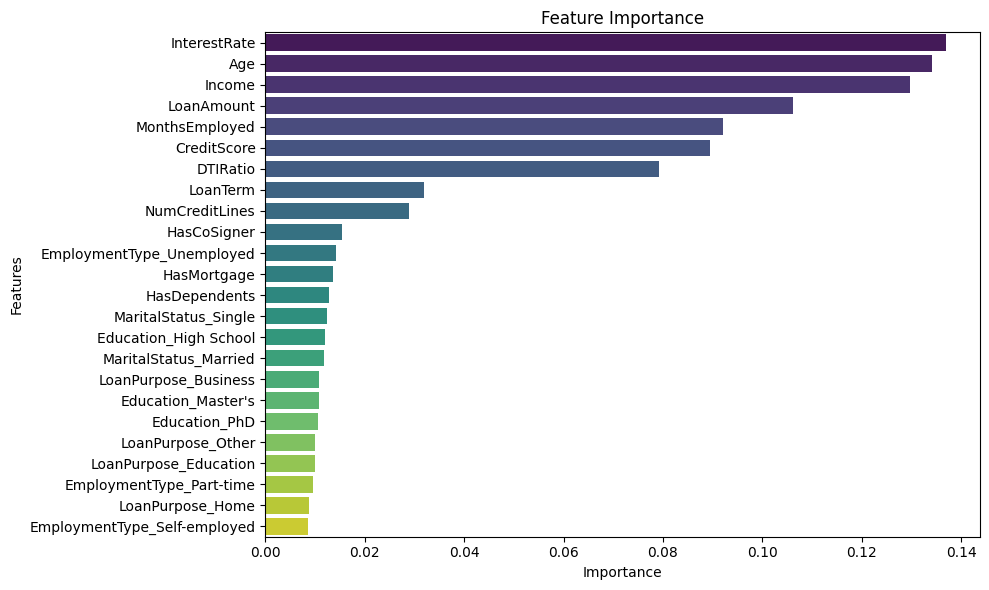

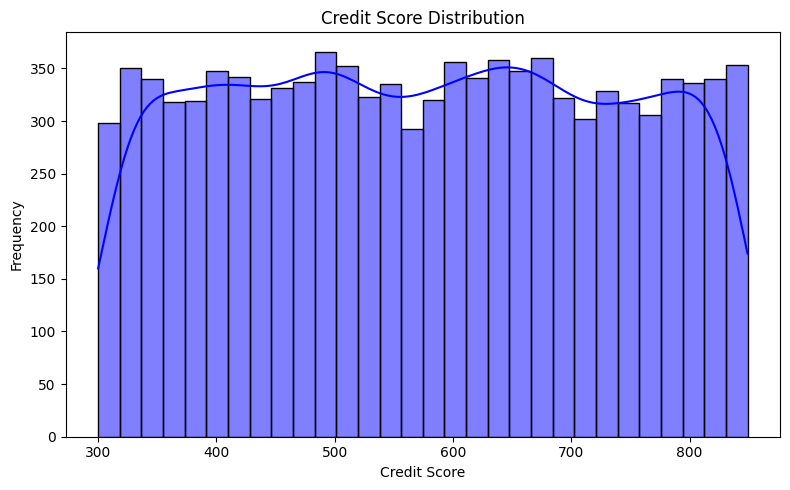

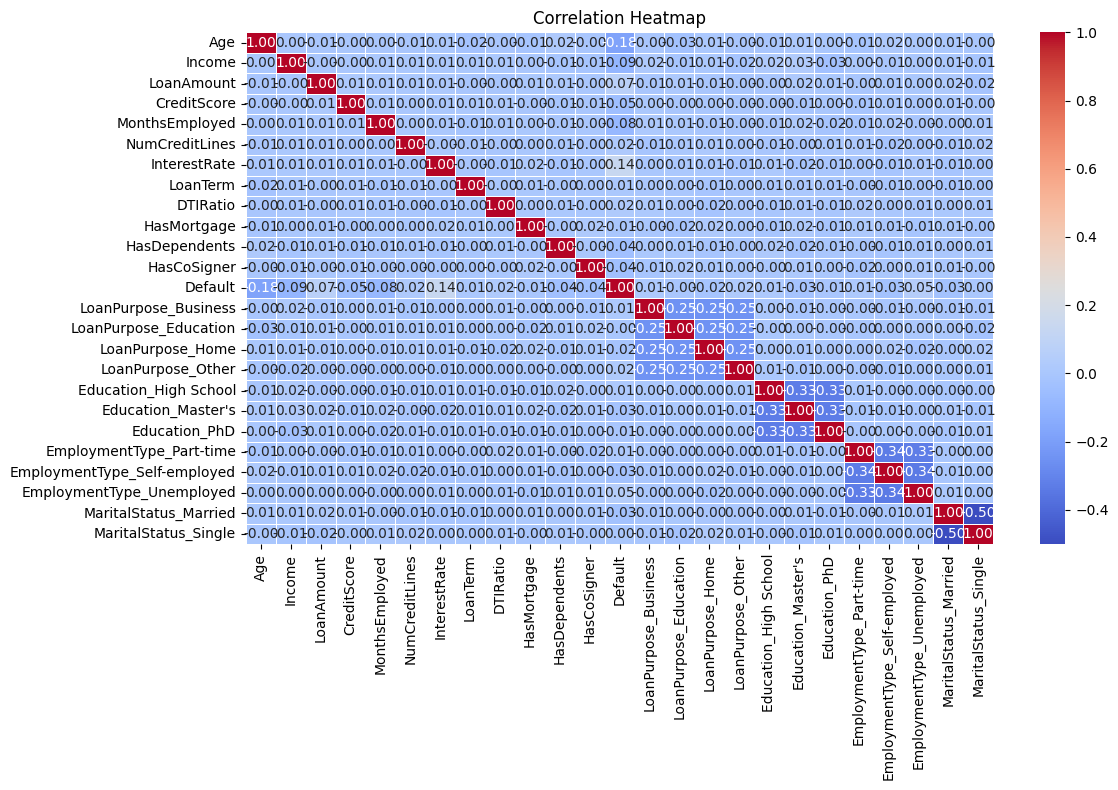

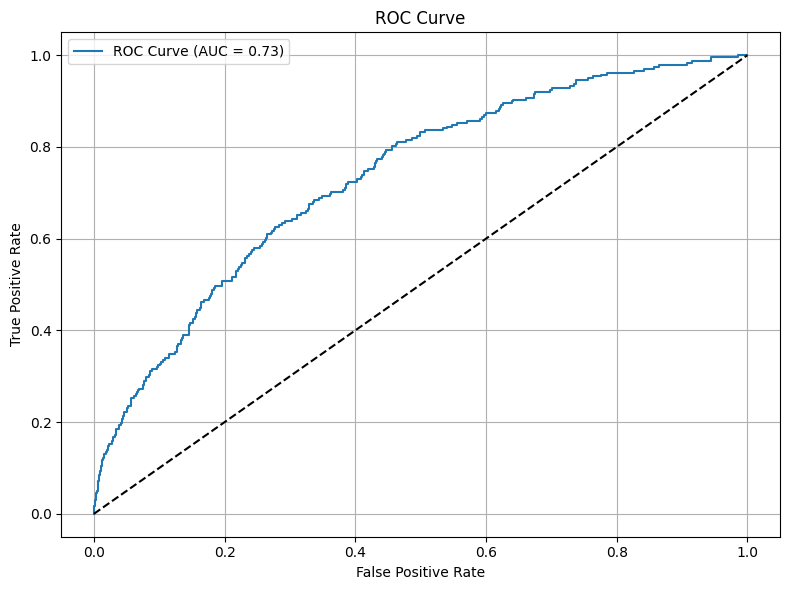

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Show plots inline
%matplotlib inline

# Load the dataset (adjust path as needed)
data = pd.read_csv('1. Predict Loan Default.csv', nrows=10000)

# Strip whitespace from column names
data.columns = data.columns.str.strip()

# Check target and column names
print("Columns:", data.columns.tolist())

# Target variable
target_column = 'Default'

# Fill missing values
data.ffill(inplace=True)

# Convert binary 'Yes'/'No' columns to 1/0
binary_cols = ['HasMortgage', 'HasDependents', 'HasCoSigner']
for col in binary_cols:
    if col in data.columns:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Encode categorical variables
categorical_cols = ['LoanPurpose', 'Education', 'EmploymentType', 'MaritalStatus']
for col in categorical_cols:
    if col in data.columns:
        top_categories = data[col].value_counts().nlargest(4).index
        data[col] = data[col].where(data[col].isin(top_categories), 'Other')
        data = pd.get_dummies(data, columns=[col], drop_first=True)

# Drop LoanID if present
if 'LoanID' in data.columns:
    data.drop('LoanID', axis=1, inplace=True)

# Ensure all columns are numeric
non_numeric_cols = data.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print("Warning: Non-numeric columns present:", non_numeric_cols.tolist())

# Downcast numeric columns to save memory
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data[col] = pd.to_numeric(data[col], downcast='float')

gc.collect()

# Split data
X = data.drop(target_column, axis=1)
y = data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("✅ Classification Report:")
print(classification_report(y_test, y_pred))
print("✅ ROC AUC Score:", roc_auc_score(y_test, y_proba))

# ==========================
# 📊 VISUALIZATIONS
# ==========================

# Feature importance
plt.figure(figsize=(10, 6))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns[indices]
sns.barplot(x=importances[indices], y=features, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Credit Score distribution
if 'CreditScore' in data.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data['CreditScore'], kde=True, bins=30, color='blue')
    plt.title('Credit Score Distribution')
    plt.xlabel('Credit Score')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()









